### Main file

In [1]:
import numpy as np 
from tools.srbm_experimental import *           # !!! Importing the experimental SRBM model !!!
from tools.functions import *
import matplotlib.pyplot as plt

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]

In [2]:
Id = create_Id(N_v = N_v, N_c = N_c, n_c_unit = n_c_unit, beta = beta_parameter, n_samples=n_samples)
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)
mnist_data = load_mnist_data(n_samples = n_samples, min_p = .00001, max_p = .98, binary = True, seed=0)

In [3]:
# heun method takes 30s for t_sim = dcmt*t_ref*100 
# euler takes less time
loc = main(W, b_v, b_c, b_h, Id = Id, dorun = True, monitors = True, mnist_data=mnist_data) # changed from create_Id to Id

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


Train accuracy: 0.09
Test accuracy: 0.08
Train accuracy: 0.09
Test accuracy: 0.097
Train accuracy: 0.09
Test accuracy: 0.097
Train accuracy: 0.175
Test accuracy: 0.199
Train accuracy: 0.14
Test accuracy: 0.166
Train accuracy: 0.105
Test accuracy: 0.114
Train accuracy: 0.095
Test accuracy: 0.113
Train accuracy: 0.17
Test accuracy: 0.18
Train accuracy: 0.195
Test accuracy: 0.213
Train accuracy: 0.195
Test accuracy: 0.211
Train accuracy: 0.19
Test accuracy: 0.196
Train accuracy: 0.2
Test accuracy: 0.214
Train accuracy: 0.35
Test accuracy: 0.322
Train accuracy: 0.38
Test accuracy: 0.366
Train accuracy: 0.21
Test accuracy: 0.181
19.40706992149353


In [4]:
locals().update(loc)

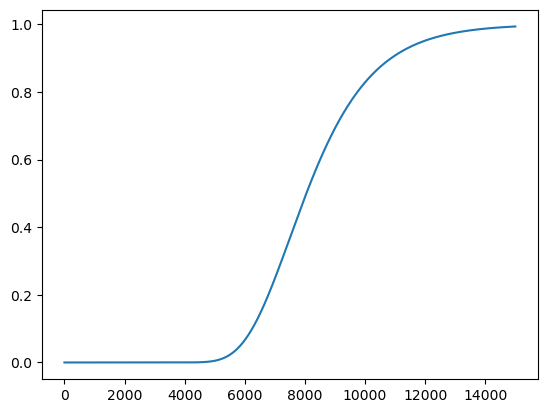

In [5]:
plot(growth_factor_list)

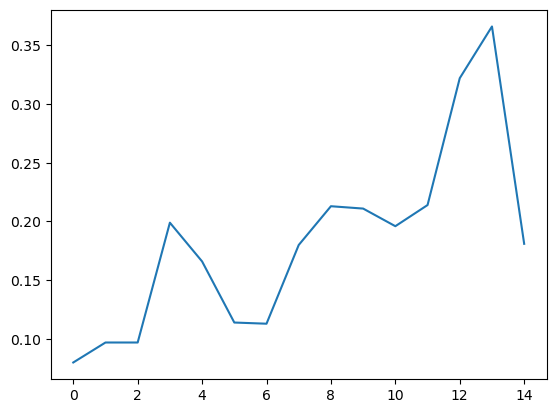

In [6]:
plot(res_hist_test)
plt.show()

In [7]:
# Why does beta get replaced by the numpy function??
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

In [8]:
#save_matrices(W, Wvh, Wch, mBv, mBh, b_c, b_v, b_h, mB, date_str, date_time_str)